In [60]:
### Regular Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [61]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

Inspired from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [62]:
def get_simple_data_train():
    x = torch.linspace(-2, 4, 300)
    x = torch.hstack([x, torch.linspace(6, 8, 300)])
    f = lambda x: torch.sin(x)
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [63]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_simple_data_train()
    
    x_all = torch.linspace(-2, 8, 1000)

    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

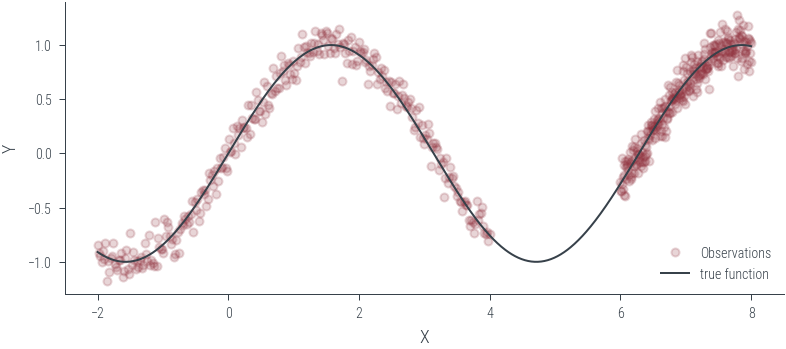

In [64]:
plot_generic()

In [186]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 24
hidden_l2_dim = 12


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [187]:
train_x, train_y, true_func = get_simple_data_train()
train_x = train_x.to(device)
train_y = train_y.to(device)


In [188]:
train_x.shape

torch.Size([600, 1])

In [189]:
test_x = torch.linspace(-2, 8, 1000)[:, None]
test_x = test_x.to(device)

In [190]:
parameters = init_params()


with torch.no_grad():
    y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [191]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)


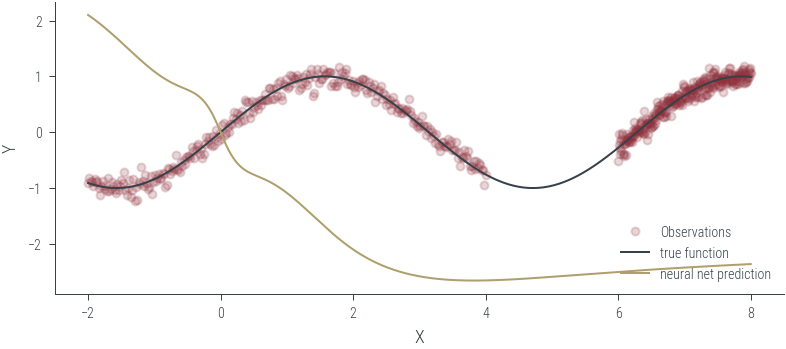

In [192]:
# Plot the untrained model
plot_predictions(test_x.cpu(), y_hat_untrained)

In [193]:
# Modify the train function to pass the dropout flag and dropout probability
def train(params, opt, fwd_func, x_train, y_train, epochs=1000, dropout=False, p=0.0):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params, p)  # Pass the dropout flag and probability to fwd_func
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 300 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params

In [194]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 1.915
Epoch 300, loss 0.096
Epoch 600, loss 0.061
Epoch 900, loss 0.045
Epoch 1200, loss 0.032
Epoch 1500, loss 0.024
Epoch 1800, loss 0.019
Epoch 2100, loss 0.016
Epoch 2400, loss 0.014
Epoch 2700, loss 0.013
Epoch 3000, loss 0.012
Epoch 3300, loss 0.011
Epoch 3600, loss 0.011
Epoch 3900, loss 0.011
Epoch 4200, loss 0.010
Epoch 4500, loss 0.010
Epoch 4800, loss 0.010
Epoch 5100, loss 0.010
Epoch 5400, loss 0.010
Epoch 5700, loss 0.010


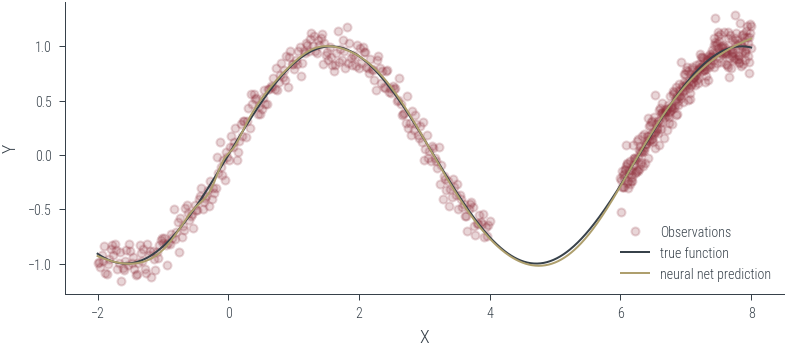

In [195]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

In [196]:
### Now adding dropout to the model by manually masking the activations
W1, b1, W2, b2, W3, b3 = parameters
h1 = torch.relu(test_x @ W1 + b1)
h1.shape


torch.Size([1000, 24])

In [197]:
# probability of dropping out each neuron
p = 0.2

In [198]:
mask = torch.rand_like(h1) > p
mask.shape

torch.Size([1000, 24])

In [199]:
h1.shape

torch.Size([1000, 24])

In [200]:
mask.sum()

tensor(19208, device='cuda:0')

In [201]:
mask.numel()

24000

In [202]:
masked_activations = h1 * mask
masked_activations.shape

torch.Size([1000, 24])

In [203]:
pd.DataFrame(masked_activations.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.000000,0.343768,1.628690,1.346068,0.0,2.020622,0.0,0.0,1.409621,...,0.0,0.0,1.823752,3.418944,0.0,0.0,0.266009,0.000000,0.0,0.800828
1,0.0,0.000000,0.342591,0.000000,0.000000,0.0,2.010309,0.0,0.0,1.404558,...,0.0,0.0,1.814826,3.401712,0.0,0.0,0.264708,1.398787,0.0,0.796879
2,0.0,1.214058,0.000000,1.611734,1.331165,0.0,1.999996,0.0,0.0,1.399495,...,0.0,0.0,1.805900,3.384480,0.0,0.0,0.000000,1.391368,0.0,0.792930
3,0.0,1.209776,0.000000,0.000000,0.000000,0.0,1.989682,0.0,0.0,1.394433,...,0.0,0.0,1.796974,0.000000,0.0,0.0,0.000000,1.383949,0.0,0.788981
4,0.0,0.000000,0.339059,1.594778,0.000000,0.0,1.979369,0.0,0.0,1.389370,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.376529,0.0,0.785032


In [204]:
pd.DataFrame(h1.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,1.222621,0.343768,1.628690,1.346068,0.0,2.020622,0.0,0.0,1.409621,...,0.0,0.0,1.823752,3.418944,0.0,0.0,0.266009,1.406207,0.0,0.800828
1,0.0,1.218339,0.342591,1.620212,1.338616,0.0,2.010309,0.0,0.0,1.404558,...,0.0,0.0,1.814826,3.401712,0.0,0.0,0.264708,1.398787,0.0,0.796879
2,0.0,1.214058,0.341414,1.611734,1.331165,0.0,1.999996,0.0,0.0,1.399495,...,0.0,0.0,1.805900,3.384480,0.0,0.0,0.263408,1.391368,0.0,0.792930
3,0.0,1.209776,0.340236,1.603256,1.323714,0.0,1.989682,0.0,0.0,1.394433,...,0.0,0.0,1.796974,3.367248,0.0,0.0,0.262107,1.383949,0.0,0.788981
4,0.0,1.205494,0.339059,1.594778,1.316263,0.0,1.979369,0.0,0.0,1.389370,...,0.0,0.0,1.788048,3.350016,0.0,0.0,0.260807,1.376529,0.0,0.785032


In [205]:
pd.DataFrame(mask.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,True,False,True,True,True,False,True,True,False,True,...,True,False,True,True,True,True,True,False,True,True
1,False,False,True,False,False,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True
2,True,True,False,True,True,True,True,False,True,True,...,True,False,True,True,True,True,False,True,True,True
3,True,True,False,False,False,False,True,True,True,True,...,True,True,True,False,True,True,False,True,False,True
4,True,False,True,True,False,False,True,True,True,True,...,True,False,False,False,True,True,False,True,True,True


In [206]:
### Rewriting the model with dropout

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #h2 = torch.sin(h1 @ W2 + b2)
    #h3 = h2 @ W3 + b3
    #return h3
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        #h2 = h2 / (1 - p)
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [207]:
# Train the model
p = 0.02
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=10000, dropout=True, p=p)

Epoch 0, loss 17.358
Epoch 300, loss 1.025
Epoch 600, loss 0.807
Epoch 900, loss 0.722
Epoch 1200, loss 0.692
Epoch 1500, loss 0.521
Epoch 1800, loss 0.553
Epoch 2100, loss 0.416
Epoch 2400, loss 0.390
Epoch 2700, loss 0.390
Epoch 3000, loss 0.442
Epoch 3300, loss 0.387
Epoch 3600, loss 0.359
Epoch 3900, loss 0.334
Epoch 4200, loss 0.335
Epoch 4500, loss 0.269
Epoch 4800, loss 0.289
Epoch 5100, loss 0.309
Epoch 5400, loss 0.249
Epoch 5700, loss 0.206
Epoch 6000, loss 0.184
Epoch 6300, loss 0.184
Epoch 6600, loss 0.186
Epoch 6900, loss 0.148
Epoch 7200, loss 0.171
Epoch 7500, loss 0.116
Epoch 7800, loss 0.142
Epoch 8100, loss 0.106
Epoch 8400, loss 0.096
Epoch 8700, loss 0.088
Epoch 9000, loss 0.078
Epoch 9300, loss 0.075
Epoch 9600, loss 0.070
Epoch 9900, loss 0.070


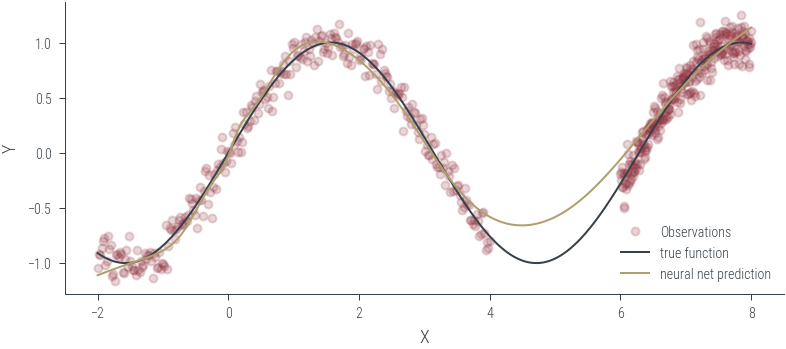

In [208]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

    

In [209]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

In [210]:
# Plot MC dropout predictions

preds = np.array(preds)
preds.shape

(100, 1000)

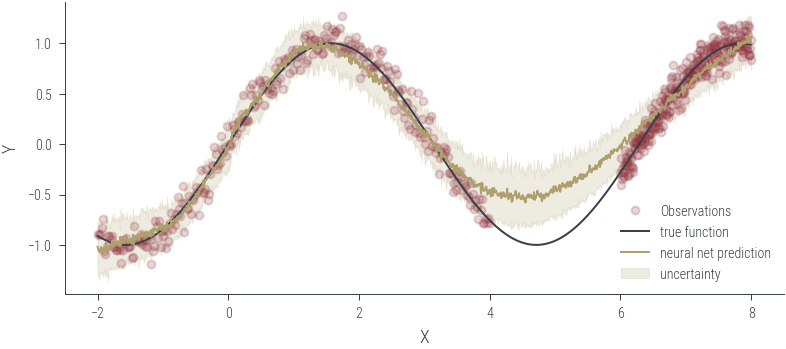

In [211]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)
